## Import functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import os
import os, glob
# from google.colab import drive
# drive.mount('/content/gdrive')

from scipy.stats import rankdata

In [2]:
def set_path(folder,output):
  data_path = output + folder + '/'
  return data_path

def get_csv_files_name(data_path):
  # List to hold the names of CSV files
  csv_files = []

  # Walk through the directory
  for file_name in os.listdir(data_path):
      # Check if the file is a CSV by looking at its extension
      if file_name.endswith('.csv'):
          csv_files.append(file_name)

  # Print out the list of CSV files
  print(csv_files)
  return csv_files

In [3]:
def get_data(csv_files,folder,data_path):
  data = pd.DataFrame()
  if folder == '20240826_csv_intensity':
    for file_name in csv_files:
      df = pd.read_csv(data_path + file_name)
      file_label_split = file_name.split('_')
      group_label = file_label_split[1]
      if group_label == 'veh':
        subject_id  = file_label_split[2]
      elif group_label == 'pargyline':
        subject_id  = file_label_split[3]
      df['group'] = group_label
      df['subject_id'] = subject_id
      print ('filename is ' + file_name)
      print('grouplabel is' + group_label)
      print('subjectid is' + subject_id)
      data = pd.concat([data, df])

    data['group_subject'] = data['group'] + '_' + data['subject_id']
    data =data[data['group']=='pargyline'].reset_index(drop=True)
  elif folder == '20240826_csv_cellcounts':
    for file_name in csv_files:
      df = pd.read_csv(data_path + file_name)
      file_label_split = file_name.split('_')
      group_label = file_label_split[0]
      if group_label == 'veh':
        subject_id  = file_label_split[1]
      elif group_label == 'pargyline':
        subject_id  = file_label_split[2][:-4]
      df['group'] = group_label
      df['subject_id'] = subject_id
      print (file_name, group_label, subject_id)
      data = pd.concat([data, df])

    data['group_subject'] = data['group'] + '_' + data['subject_id']
    data =data[data['group']=='pargyline'].reset_index(drop=True)

  return data

In [4]:
# get shared 'LabelAbrv' values among each 'group_subject' in a dataframe, intensity_data

def get_shared_label_abrv(dataframe):
    # Group the dataframe by 'group_subject' and convert 'LabelAbrv' to sets
    grouped = dataframe.groupby('group_subject')['LabelAbrv'].apply(set)

    # Find the intersection of all sets
    shared_labels = set.intersection(*grouped)

    return shared_labels


## Import datasets and output path

In [8]:
output =  'Example_data/' #'/content/gdrive/MyDrive/Colab Notebooks/Heatmap_Ben_cfos/'

In [9]:
folder = '20240826_csv_cellcounts'
data_path = set_path(folder,output)
density_data = get_data(get_csv_files_name(data_path),folder,data_path)

folder = '20240826_csv_intensity'
data_path = set_path(folder,output)
intensity_data = get_data(get_csv_files_name(data_path),folder,data_path)

['pargyline_10_04.csv', 'pargyline_10_02.csv', 'pargyline_10_01.csv', 'veh_02_depth_6.csv', 'veh_01_depth_6.csv', 'veh_05_depth_6.csv', 'veh_04_depth_6.csv', 'veh_03_depth_6.csv', 'pargyline_10_03.csv', 'pargyline_10_05.csv']
pargyline_10_04.csv pargyline 04
pargyline_10_02.csv pargyline 02
pargyline_10_01.csv pargyline 01
veh_02_depth_6.csv veh 02
veh_01_depth_6.csv veh 01
veh_05_depth_6.csv veh 05
veh_04_depth_6.csv veh 04
veh_03_depth_6.csv veh 03
pargyline_10_03.csv pargyline 03
pargyline_10_05.csv pargyline 05
['intensity_veh_01_depth_6.csv', 'intensity_pargyline_10_01_depth_6.csv', 'intensity_veh_02_depth_6.csv', 'intensity_veh_04_depth_6.csv', 'intensity_pargyline_10_04_depth_6.csv', 'intensity_pargyline_10_03_depth_6.csv', 'intensity_veh_05_depth_6.csv', 'intensity_veh_03_depth_6.csv', 'intensity_pargyline_10_02_depth_6.csv', 'intensity_pargyline_10_05_depth_6.csv']
filename is intensity_veh_01_depth_6.csv
grouplabel isveh
subjectid is01
filename is intensity_pargyline_10_01_de

## Generate heatmap with normalized density and density

In [11]:
mouse = density_data['subject_id'].unique()

In [12]:
# in each dataset, find valid region shared by each subject
shared_labels_intensity = get_shared_label_abrv(intensity_data)
print ('intensity has valid regions of ' + str(len(shared_labels_intensity)))
shared_labels_density = get_shared_label_abrv(density_data)
print ('density has valid regions of ' + str(len(shared_labels_density)))

# get the intersection of density and intensity
shared_labels = shared_labels_intensity.intersection(shared_labels_density)
print ('shared regions of ' + str(len(shared_labels)))

intensity has valid regions of 294
density has valid regions of 184
shared regions of 184


In [13]:
def get_normalized_density(mouse,density_data):
  new_density_data = pd.DataFrame()
  for subject_id in mouse:
    each_density_data = density_data[density_data['subject_id'] == subject_id]
    try:
      mean_density = each_density_data['Density (#of cells/mm3)'].mean()
    except:
      each_density_data['Density (#of cells/mm3)'] = each_density_data['Count'].values/each_density_data['Volume(mm^3)'].values
      mean_density = each_density_data['Density (#of cells/mm3)'].mean()
    each_density_data['Normalized Density (#of cells/mm3)'] = each_density_data['Density (#of cells/mm3)']/mean_density

    mean_intensity = each_density_data['Mean'].mean()
    each_density_data['Normalized Intensity'] = each_density_data['Mean']/mean_intensity
    new_density_data = pd.concat([new_density_data, each_density_data])
  return new_density_data

In [14]:
# data selection based on shared labels
filter_intensity_data = intensity_data[intensity_data['LabelAbrv'].isin(shared_labels)]
filter_density_data = density_data[density_data['LabelAbrv'].isin(shared_labels)]

# sort two datasets based on the 'group_subject' and 'labelAbrv'
filter_intensity_data = filter_intensity_data.sort_values(by=['group_subject','LabelAbrv']).reset_index(drop=True)
filter_density_data = filter_density_data.sort_values(by=['group_subject','LabelAbrv']).reset_index(drop=True)

# merge density and intensity
merged_df = filter_density_data.copy()
merged_df['Mean'] = filter_intensity_data['Mean']

# get the normalized data
new_density_data = get_normalized_density(mouse,merged_df)

/tmp/ipykernel_5796/2978422722.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_density_data['Density (#of cells/mm3)'] = each_density_data['Count'].values/each_density_data['Volume(mm^3)'].values
/tmp/ipykernel_5796/2978422722.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_density_data['Normalized Density (#of cells/mm3)'] = each_density_data['Density (#of cells/mm3)']/mean_density
/tmp/ipykernel_5796/2978422722.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [15]:
# get the region info
regions =new_density_data['RegionalName'].unique()

region_num_info = {}
for i, region in enumerate(regions):
    # Filter data for the group
    data_selected= new_density_data[new_density_data['RegionalName'] == region].reset_index(drop=True)
    region_num_info[region] = len(data_selected)

In [16]:
# describe the density and normalized density
new_density_data.describe()

,LabelID,ParentID,Count,Volume(mm^3),Mean,Density (#of cells/mm3),Normalized Density (#of cells/mm3),Normalized Intensity
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,568.038043,619.396739,298.880435,0.846011,129.693668,618.209433,1.000000,1.000000
std,330.823162,314.529409,702.206624,1.540325,58.292945,1104.680706,1.837801,0.319262
min,4.000000,21.000000,1.000000,0.003000,6.852850,1.375516,0.003391,0.074945
25%,252.250000,323.000000,18.000000,0.143000,89.786720,81.126743,0.147539,0.797975
50%,609.000000,645.000000,76.000000,0.329500,116.052405,250.000000,0.441788,0.976406
75%,868.250000,875.000000,274.500000,0.820500,160.158195,723.760190,1.003770,1.196896
max,1123.000000,1132.000000,9288.000000,10.863000,438.661060,16666.666667,28.358247,2.208940


In [17]:
# remove the first string component in the column
new_density_data['LabelAbrv'] = new_density_data['LabelAbrv'].str[1:]
new_density_data = new_density_data.reset_index(drop=True)
new_density_data.to_csv(output + 'new_density_data.csv')

Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains NaN or None: False
No NaN values found in the DataFrame.
Contains N

/tmp/ipykernel_5796/1222138299.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 1])


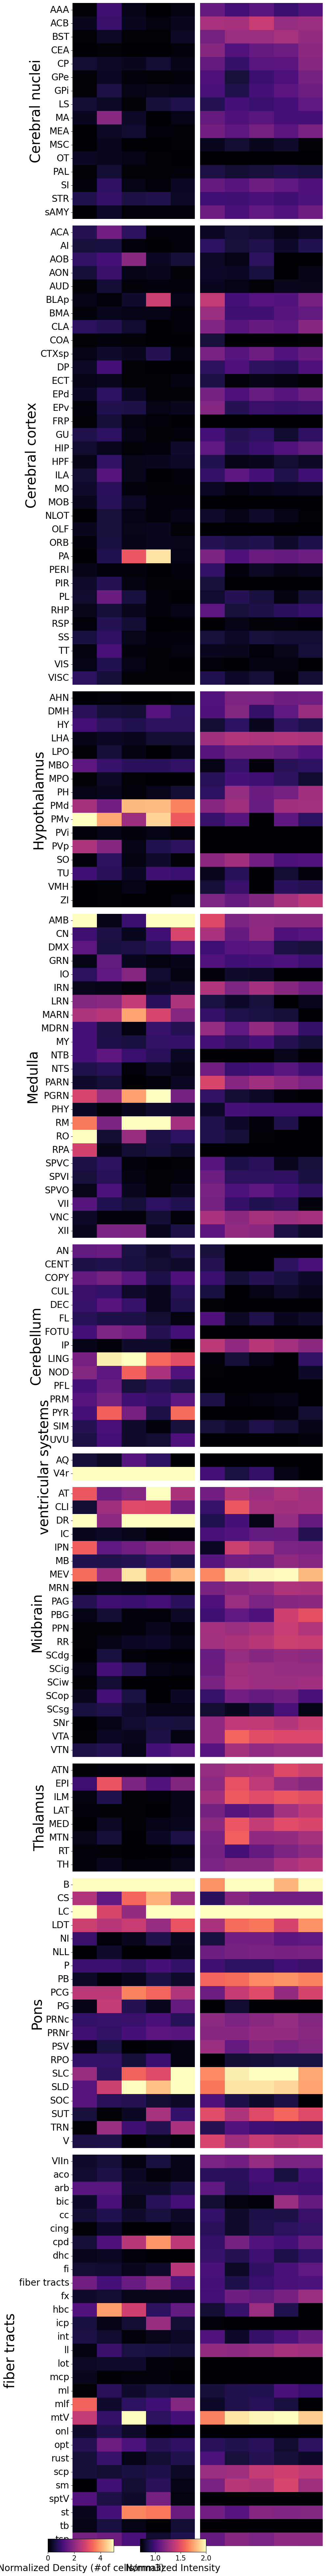

In [18]:
# Normalize the lengths to get proportions for subplot sizes
total_length = sum(region_num_info.values())
height_ratios = [region_num_info[group] / total_length for group in regions]

# Create a figure with subplots of varying heights
fig, axes = plt.subplots(len(regions), 2, figsize=(10, 80), gridspec_kw={'height_ratios': height_ratios}, sharex=True, sharey=False)

heatmaps = []

# Iterate over each region to plot the heatmaps
for count, paras in enumerate(['Normalized Density (#of cells/mm3)','Normalized Intensity']):
  for i, region in enumerate(regions):
      # Filter data for the specific region
      data_selected = new_density_data[new_density_data['RegionalName'] == region].reset_index(drop=True)
      data_selected_matrix = data_selected.pivot(index="LabelAbrv", columns="group_subject", values=paras)
      # check whether it contains Nan
      contains_nan = data_selected_matrix.isna().any().any()
      print("Contains NaN or None:", contains_nan)
      if data_selected_matrix.isna().any().any():
        # Drop rows with any NaN values
        data_selected_matrix = data_selected_matrix.dropna()
        print("Rows with NaN values have been removed.")
      else:
        data_selected_matrix = data_selected_matrix
        print("No NaN values found in the DataFrame.")

      # Create heatmap in the corresponding subplot
      if paras == 'Density (#of cells/mm3)':
        vlimit = [0, 8000]
        cbar_name = 'Density (#of cells/mm3)'
      elif paras == 'Mean':
        vlimit = [0,500]
        cbar_name = 'Intensity'
      elif paras == 'density_minus_intensity':
        vlimit = [0,200]
        cbar_name = 'Absolute delta rank'
      elif paras == 'Normalized Density (#of cells/mm3)':
        vlimit = [0, 5]
        cbar_name = 'Normalized Density (#of cells/mm3)'
      elif paras == 'Normalized Intensity':
        vlimit = [0.7, 2]
        cbar_name = 'Normalized Intensity'
      heatmap = sns.heatmap(data_selected_matrix, ax=axes[i,count], cmap="magma", vmin=vlimit[0], vmax=vlimit[1],cbar=False)
      heatmaps.append(heatmap)

      # Adjust font size for y-axis labels
      axes[i,count].set_yticklabels(axes[i,count].get_yticklabels(), rotation=0, fontsize=20)  # Adjust fontsize as needed

      # Adjust font size for x-axis labels
      axes[i,count].set_xticklabels(axes[i,count].get_xticklabels(), rotation=45, fontsize=20)  # Adjust fontsize as needed
      axes[i,count].set_xticks([])
      # Setting the title for each subplot
      axes[i,count].set_ylabel(region[6:], fontsize=30)
      axes[i,count].set_xlabel('')
      if count !=0:
        axes[i,count].set_yticklabels([])
        axes[i,count].set_yticks([])
        axes[i,count].set_ylabel('')
      else:
        axes[i,count].set_ylabel(region[6:], fontsize=30)
      axes[i,count].axvline(x=5, color='white', linestyle='-', linewidth=2)
      axes[i,count].axvline(x=10, color='white', linestyle='-', linewidth=2)


  # Adding a color bar for each column (parameter)
  cbar_ax = fig.add_axes([0.15 + count * 0.28, 0.03, 0.2, 0.005])  # Reduced height and adjusted vertical position
  cbar = fig.colorbar(heatmaps[-1].collections[0], cax=cbar_ax, orientation='horizontal')
  cbar.ax.tick_params(labelsize=15)  # Adjust color bar tick label font size
  cbar.set_label(cbar_name, size=20)  # Set

# Adding a title to the color bar
fig.subplots_adjust(hspace=0.5,wspace = 0.5)  # Reduced vertical and horizonal spacing
plt.tight_layout(rect=[0, 0.03, 1, 1])

plt.savefig(output + '2024_08_28_heatmap_nomalizeddensity_normalizedintensity.svg', dpi=400, bbox_inches='tight')
plt.savefig(output + '2024_08_28_heatmap_nomalizeddensity_normalizedintensity.png', dpi=400, bbox_inches='tight')

## Reshape the density and intensity csv files

In [19]:
def get_data(csv_files,folder,data_path):
  data = pd.DataFrame()
  if folder == '20240826_csv_intensity':
    for file_name in csv_files:
      df = pd.read_csv(data_path + file_name)
      file_label_split = file_name.split('_')
      group_label = file_label_split[1]
      if group_label == 'veh':
        subject_id  = file_label_split[2]
      elif group_label == 'pargyline':
        subject_id  = file_label_split[3]
      df['group'] = group_label
      df['subject_id'] = subject_id
      print ('filename is ' + file_name)
      print('grouplabel is' + group_label)
      print('subjectid is' + subject_id)
      data = pd.concat([data, df])

    data['group_subject'] = data['group'] + '_' + data['subject_id']

  elif folder == '20240826_csv_cellcounts':
    for file_name in csv_files:
      df = pd.read_csv(data_path + file_name)
      file_label_split = file_name.split('_')
      group_label = file_label_split[0]
      if group_label == 'veh':
        subject_id  = file_label_split[1]
      elif group_label == 'pargyline':
        subject_id  = file_label_split[2][:-4]
      df['group'] = group_label
      df['subject_id'] = subject_id
      print (file_name, group_label, subject_id)
      data = pd.concat([data, df])

    data['group_subject'] = data['group'] + '_' + data['subject_id']

  return data

In [20]:
folder = '20240826_csv_cellcounts'
data_path = set_path(folder,output)
density_data = get_data(get_csv_files_name(data_path),folder,data_path)

folder = '20240826_csv_intensity'
data_path = set_path(folder,output)
intensity_data = get_data(get_csv_files_name(data_path),folder,data_path)

['pargyline_10_04.csv', 'pargyline_10_02.csv', 'pargyline_10_01.csv', 'veh_02_depth_6.csv', 'veh_01_depth_6.csv', 'veh_05_depth_6.csv', 'veh_04_depth_6.csv', 'veh_03_depth_6.csv', 'pargyline_10_03.csv', 'pargyline_10_05.csv']
pargyline_10_04.csv pargyline 04
pargyline_10_02.csv pargyline 02
pargyline_10_01.csv pargyline 01
veh_02_depth_6.csv veh 02
veh_01_depth_6.csv veh 01
veh_05_depth_6.csv veh 05
veh_04_depth_6.csv veh 04
veh_03_depth_6.csv veh 03
pargyline_10_03.csv pargyline 03
pargyline_10_05.csv pargyline 05
['intensity_veh_01_depth_6.csv', 'intensity_pargyline_10_01_depth_6.csv', 'intensity_veh_02_depth_6.csv', 'intensity_veh_04_depth_6.csv', 'intensity_pargyline_10_04_depth_6.csv', 'intensity_pargyline_10_03_depth_6.csv', 'intensity_veh_05_depth_6.csv', 'intensity_veh_03_depth_6.csv', 'intensity_pargyline_10_02_depth_6.csv', 'intensity_pargyline_10_05_depth_6.csv']
filename is intensity_veh_01_depth_6.csv
grouplabel isveh
subjectid is01
filename is intensity_pargyline_10_01_de

In [21]:
# reshape it according to each subejct as a column
re_intensity_data = intensity_data.pivot(index=['LabelAbrv','LabelName','RegionalName'], columns='group_subject', values='Mean')
# assign 0 to the NaNS
re_intensity_data = re_intensity_data.fillna(0)

# reshape density data
re_density_data = density_data.pivot(index=['LabelAbrv','LabelName'], columns='group_subject', values=['Count','Volume(mm^3)'])
# assign 0 to the NaNS
re_density_data = re_density_data.fillna(0)

In [22]:
re_intensity_data.to_csv(output + '20240827_res_intensity_data_val_Mean.csv')
re_density_data.to_csv(output + '20240827_res_density_data_val_Count.csv')